1. Попробуйте видоизменить параметры разобранной на уроке двухслойной нейронной сети таким образом, чтобы улучшить ее точность.
2. Проведите анализ — что приводит к ухудшению точности нейронной сети?
3. Что приводит к увеличению ее точности?

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

**Загрузка данных, нормализация, разделение на train, test**

(1797, 64)


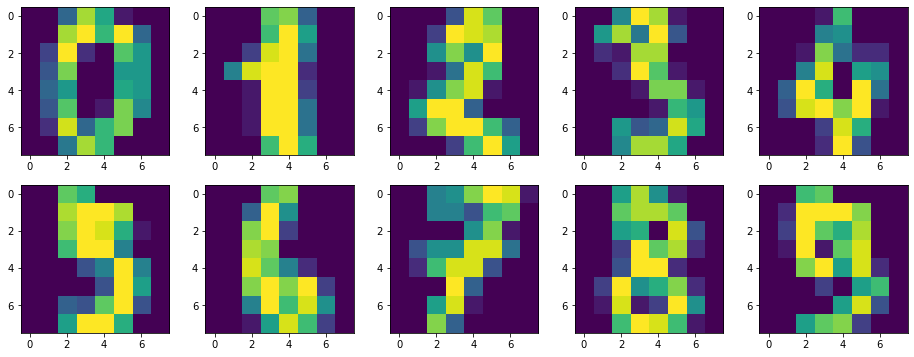

In [2]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


# Подготовка тренировочных данных
X, y = load_digits(return_X_y=True)
print(X.shape) # расскоментируйте, чтобы размер данных

# репрезентация данных
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i,:].reshape([8, 8]))

    
def to_one_hot(Y):
    n_col = np.max(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1
    return binarized

In [3]:
# формирование входных данных
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# формирование выходных данных(результатов)
y = y.flatten()
y = to_one_hot(y)

display(y, y.shape)

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

(1797, 10)

In [4]:
from sklearn.model_selection import train_test_split

# Разделение данных на тренировочные и тестовые
# ДОБАВЛЕНО Зафиксируем* состояние генератора псевдослучайных чисел (random_state) - для воспроизводимости
# *в коде из урока не было зафиксировано
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
X_train.shape, X_test.shape

((1203, 64), (594, 64))

**Реализация нейронной сети, которая рассматривалась на уроке**

С теми же гиперпараметрами

In [5]:
# вычисление сигмоид функции
def sigmoid(x):
    x = np.clip(x, a_min=-500, a_max=500)
    return 1 / (1 + np.exp(-x))

# вычисление производной от сигмоид функции
def sigmoid_deriv(x):
    return sigmoid(x) * (1 - sigmoid(x))

In [6]:
%%time

# Обучение нейронной сети

# определим число нейронов скрытого слоя
neuron_numb = 5

# присваивание случайных весов
np.random.seed(1)
w0 = np.random.random((64, neuron_numb))  # для входного слоя    - 64 входа, neuron_numb выходов
w1 = np.random.random((neuron_numb, 10))  # для внутреннего слоя - neuron_numb входов, 10 выходов

# скорость обучения (learning rate)
learning_rate = 0.1

# количество итераций
num_epochs = 100

# массив для ошибок, чтобы потом построить график
errors = []
metrics = []

# процесс обучения
for i in range(num_epochs):

    # прямое распространение(feed forward)
    layer0 = X_train
    layer1 = sigmoid(np.dot(layer0, w0))
    layer2 = sigmoid(np.dot(layer1, w1))

    # обратное распространение (back propagation)
    #  с использованием градиентного спуска
    layer2_error = layer2 - y_train  # производная функции потерь
    layer2_grad = layer2_error * sigmoid_deriv(layer2)
    
    layer1_error = layer2_grad.dot(w1.T)
    layer1_grad = layer1_error * sigmoid_deriv(layer1)
    
    w1 -= layer1.T.dot(layer2_grad) * learning_rate
    w0 -= layer0.T.dot(layer1_grad) * learning_rate
    
    # ошибка модели
    error = np.mean(np.abs(layer2_error))
    errors.append(error)
    
    # метрики качества
    preds = np.argmax(layer2, axis=1)
    labels = np.argmax(y_train, axis=1)
    accuracy = (preds == labels).sum() * 100 / len(labels)
    metrics.append(accuracy)

CPU times: user 416 ms, sys: 743 ms, total: 1.16 s
Wall time: 163 ms


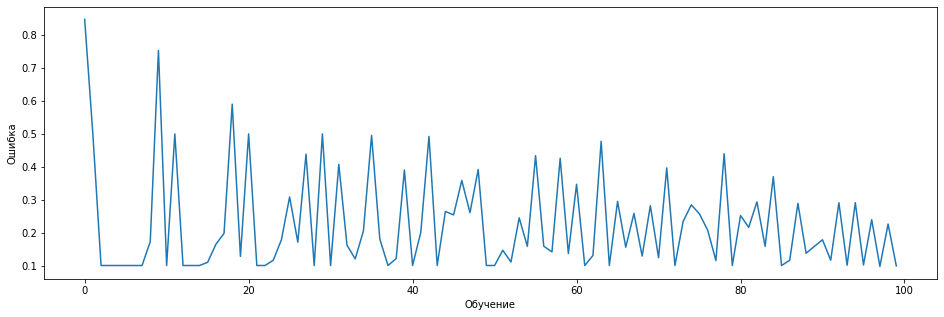

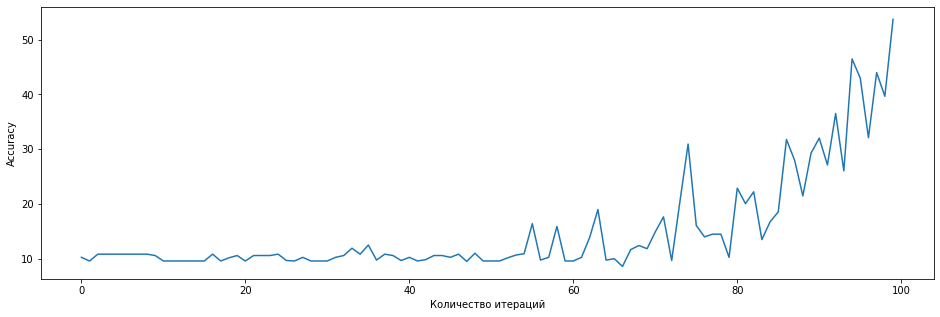

In [7]:
# Демонстрация полученных результатов
# Диаграмма точности в зависимости от обучения
plt.figure(figsize=(16, 5))
plt.plot(errors)
plt.xlabel('Обучение')
plt.ylabel('Ошибка')
plt.show()

plt.figure(figsize=(16, 5))
plt.plot(metrics)
plt.xlabel('Количество итераций')
plt.ylabel('Accuracy')
plt.show()

Некоторые предварительные выводы:

- Замечено, что производная сигмоиды берется не от выхода сумматора (матричное произведение значений на веса), а от выхода функции активации. Т.е. производная сигмоиды берется от сигмоиды выхода сумматора;
- Не используется смещение (bias).

Остановимся подробнее на первой проблеме. 

В приведенной реализации получается: 

$$ \sigma^{'}_{\sigma_{x}} = \sigma_{\sigma_{x}} * (1 - \sigma_{\sigma_{x}}) $$

вместо:

$$ \sigma^{'}_{x} = \sigma_{x} * (1 - \sigma_{x}) $$

Вероятно это было сделано во избежание "паралича сети" при начале обучения. 

Выход функции активации ограничен значениями от 0 до 1: $ \sigma_{output} \in (0, 1) $. Если, в приведенной реализации, брать производную сигмоиды от выхода сумматора, то "паралич сети" неминуем, т.к. в качестве начальных весов используются случайные значения из равномерного распределения: $ weights \in (0, 1) $. При этом, сами данные были нормированы (принимают значения в диапазоне от 0 до 1). 

Таким образом, мы получаем значение на выходе, пропорциональное количеству пар вес-значение, и выход сумматора принимает значения: $ output \in (0, \infty) $. 

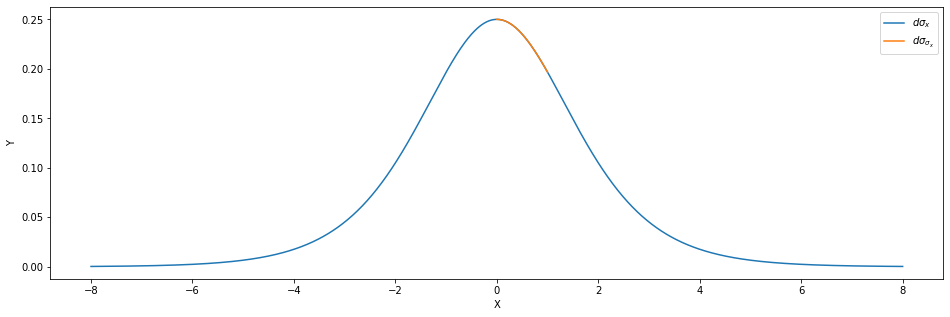

In [8]:
dots_o = np.linspace(-8, 8, 1000)
dots_sigm_o = sigmoid(dots_o)

plt.figure(figsize=(16, 5))
plt.plot(dots_o, sigmoid_deriv(dots_o), label="$d\sigma_{x}$")
plt.plot(dots_sigm_o, sigmoid_deriv(dots_sigm_o), label="$d\sigma_{\sigma_{x}}$")
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
# plt.title('Производная сигмоиды')
plt.show()

Как видно из графика - при значениях после сумматора $ output \in (-\infty, -6) \cup (6, +\infty) $, производная от сигмоиды приближается к нулю. Т.е. при больших значениях производная сигмоиды занулит градиент. 

Приведенная реализация решает эту проблему (оранжевый график).

Визуализация зависимости значения выхода от количества пар вес-значение:

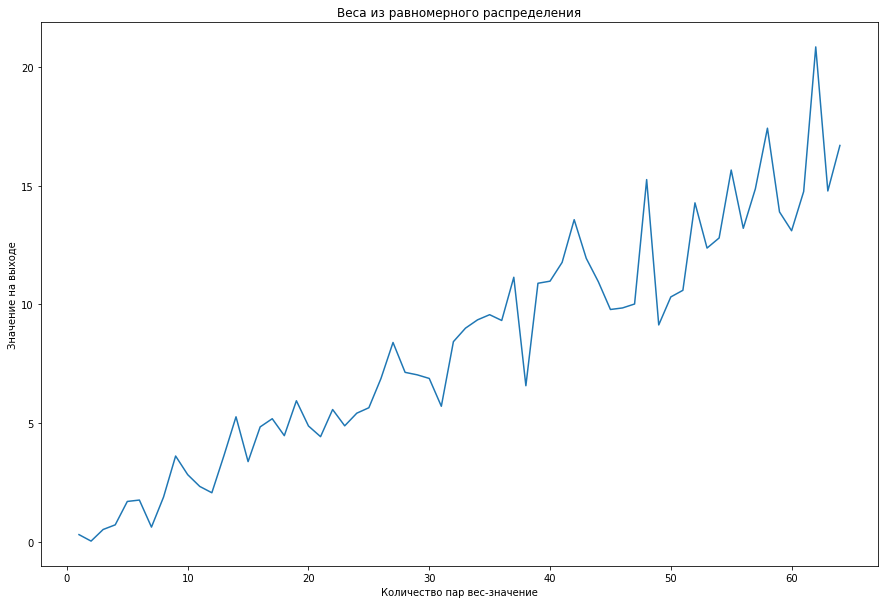

In [9]:
def even_dist(x):
    np.random.seed(1)
    for i in x:
        yield np.random.random(i) @ np.random.random(i)

dots = range(1, 65)

plt.figure(figsize=(15, 10))

plt.plot(dots, list(even_dist(dots)))
plt.xlabel('Количество пар вес-значение')
plt.ylabel('Значение на выходе')
plt.title('Веса из равномерного распределения')
plt.show()

В качестве альтернативы предлагается использовать начальные веса принимающие случайные значения из нормального распределения с математическим ожиданием равным нулю. Таким образом среднее по выходам будет приближаться к нулю. Тем самым получится снизить вероятность зануления градиента при большой ошибке.

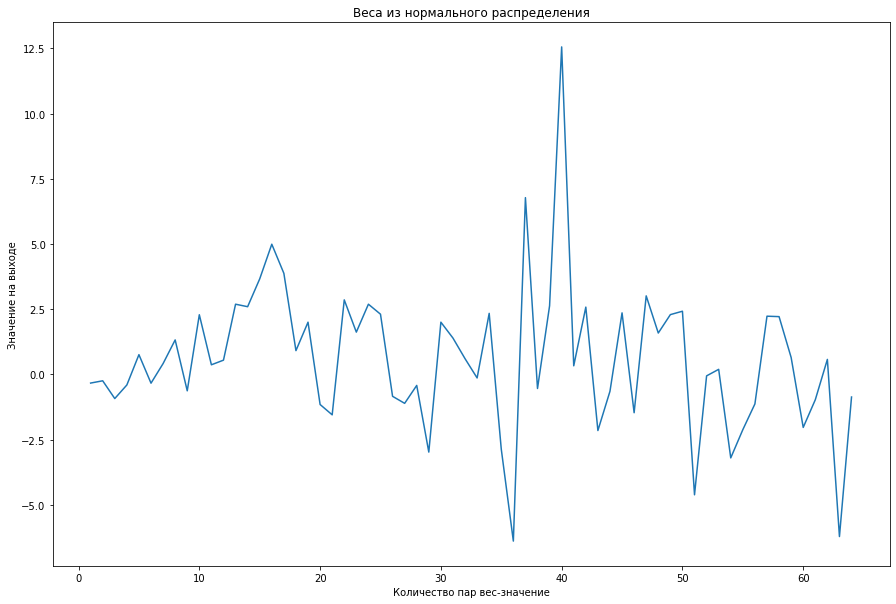

In [10]:
def normal_dist(x):
    np.random.seed(1)
    for i in x:
        yield np.random.random(i) @ np.random.randn(i)

dots = range(1, 65)

plt.figure(figsize=(15, 10))

plt.plot(dots, list(normal_dist(dots)))
plt.xlabel('Количество пар вес-значение')
plt.ylabel('Значение на выходе')
plt.title('Веса из нормального распределения')
plt.show()

Как видно из графика - дисперсия увеличивается по мере увеличения количества пар вес-значение, но вместе с тем значения на выходе не так сильно отходят от нуля (где производная от сигмоиды имеет наибольшее значение), как при использовании весов из равномерного распределения.

In [11]:
# возьмем один пример 
sample = X_train[0]

sample.shape

(64,)

In [12]:
seed = 1
np.random.seed(seed)

# веса распределенные равномерно
even_dist_w = np.random.random((64, 10))
# веса распределенные нормально
normal_dist_w = np.random.randn(64, 10)

output_even = sample @ even_dist_w
output_normal = sample @ normal_dist_w

display(output_even, output_normal)

array([ 8.96659238,  9.89714619, 10.35369073,  9.37963645,  9.4911379 ,
        9.93981676, 10.00534175,  9.33232448,  9.99380332,  8.51559807])

array([ 0.66126936,  5.28084046,  0.14408045, -7.01830399, -1.84174176,
       -3.19448496,  4.13547957,  4.24524483,  0.9758729 ,  0.38989179])

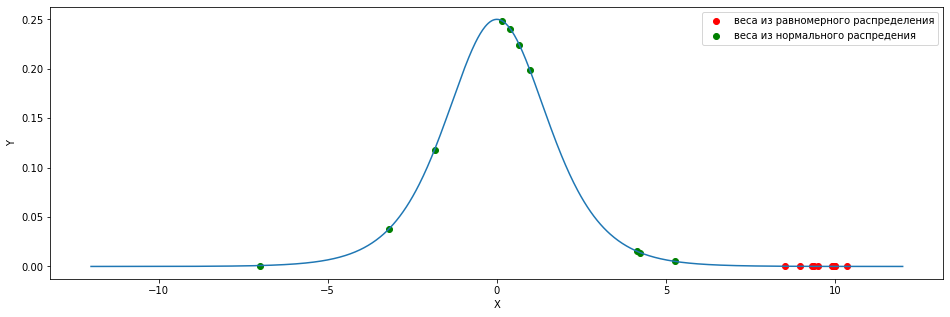

In [13]:
dots = np.linspace(-12, 12, 1000)

plt.figure(figsize=(16, 5))
plt.plot(dots, sigmoid_deriv(dots))
plt.scatter(output_even, sigmoid_deriv(output_even), c='r', label='веса из равномерного распределения')
plt.scatter(output_normal, sigmoid_deriv(output_normal), c='g', label='веса из нормального распредения')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

Как видно из графика: при весах из нормального распределения производная сигмоиды принимает более высокие значения, в сравнении со значениями при весах из равномерного распределения.

С учетом выводов, сделанных ранее, реализуем "конструктор" для создания нейронных сетей.

In [14]:
class InputLayer:
    '''
    Входной слой. Не имеет весов. На выходе данные без изменений.
    
    input_shape - (int) размер принимаемого массива, равен output_shape
    
    '''
    def __init__(self, input_shape):
        self.output_shape = input_shape
        
    def backward_pass(self, err, eta):
        return

    def output(self, input_data):
        self.output_ = input_data * np.ones(self.output_shape)
        return self.output_

In [15]:
class Layer:
    '''
    
    n_num (int) - количество узлов(нейронов) в слое;
    
    prev_layer (Layer/InputLayer) - предыдущий слой;
    
    add_bias (bool) - default = True, добавляет свободный коэффициент (bias);
    
    random_state (int) - default = None, фиксирует состояние генератора псевдослучайных чисел, 
    для воспроизводимости результатов.
    
    '''
    def __init__(self, n_num, prev_layer, add_bias=True, random_state=None):
        self.prev_layer = prev_layer
        self.output_shape = n_num
        self.add_bias = add_bias
        self.bias = 0
        np.random.seed(random_state)
        self.w = np.random.randn(prev_layer.output_shape, n_num)
        if self.add_bias:
            self.bias = np.random.randn(1, n_num)
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def sigmoid_deriv(self, z):
        sigma = self.sigmoid(z)
        return sigma * (1 - sigma)
    
    def forward_pass(self, data):
        
        # записываем в переменную экземпляра, чтобы не пересчитывать несколько раз
        self.summarized = (data @ self.w) + self.bias
        return self.sigmoid(self.summarized)
    
    def backward_pass(self, err, learning_rate):
        # вычисление градиента
        grad = err * self.sigmoid_deriv(self.summarized)
        
        # вычисление ошибки
        err = grad @ self.w.T
        
        # передача ошибки в предыдущий слой (для вычисления градиента и обновления весов)
        self.prev_layer.backward_pass(err, learning_rate)
        
        # обновление весов данного слоя
        self.w -= (self.prev_layer.output_.T @ grad) * learning_rate
        if self.add_bias:
            self.bias -= np.sum(grad, axis=0) * learning_rate
    
    def output(self, input_data):
        # выход предыдущего слоя
        data = self.prev_layer.output(input_data)
        
        # записываем в переменную экземпляра, чтобы не пересчитывать несколько раз
        self.output_ = self.forward_pass(data)
        return self.output_

In [16]:
class NNetwork:
    '''
   
    output_layer (Layer) - выходной слой нейронной сети;
    
    learning_rate (int/float) - скорость обучения.
    
    '''
    def __init__(self, output_layer, learning_rate=0.01):
        self.output_layer = output_layer
        self.learning_rate = learning_rate
    
    def mae(self, y, pred):
        return np.mean(np.abs(y - pred))
    
    def mae_deriv(self, y, pred):
        return pred - y
    
    def accuracy(self, y, pred):
        return (pred == y).sum() / len(y)
    
    def fit(self, X, y, valid_set=None, n_epochs=100):        
        history = {
            'train': {
                'losses': [], 
                'metrics': []
            },
            'valid': {
                'metrics': []
            }
        }
        
        for i in range(1, n_epochs + 1):
            
            if valid_set:
                # предсказания и метрики для валидационного набора
                valid_preds = np.argmax(self.predict(valid_set[0]), axis=1)
                valid_labels = np.argmax(valid_set[1], axis=1)
                # добавление в history метрики на валидационном наборе
                history['valid']['metrics'].append(self.accuracy(valid_labels, valid_preds))
            
            # предикт для трейна делается после предикта на валидационном наборе
            # чтобы перезаписать переменные экземпляров класса Layer
            train_pred = self.predict(X)
            
            # предсказания и метрики для трейна
            train_preds = np.argmax(train_pred, axis=1)
            train_labels = np.argmax(y, axis=1)

            history['train']['losses'].append(self.mae(y, train_pred))
            history['train']['metrics'].append(self.accuracy(train_labels, train_preds))
            
#             if i % 10 == 0:
#                 print(f'Epoch: {i}, loss = {loss:.4f}, accuracy = {accuracy:.4f}')
            
            # вычисление ошибки для трейна и передача для обновления весов
            err = self.mae_deriv(y, train_pred)
            self.output_layer.backward_pass(err, self.learning_rate)

        return history
    
    def predict(self, X):
        return self.output_layer.output(X)

Повторим архитектуру, предложенную на уроке. 

Два слоя: один скрытый (5 нейронов), один выходной (10 нейронов). 
Без смещения (bias). Скорость обучения (learning rate) и количество эпох оставим без изменений

Но с производной сигмоиды по выходу сумматора и весами из нормального распределения. 

In [17]:
%%time
seed = 1

L = InputLayer(64)
L = Layer(5, L, add_bias=False, random_state=seed)
L = Layer(10, L, add_bias=False, random_state=seed)

model = NNetwork(L, learning_rate=1e-1)

history = model.fit(X_train, y_train, n_epochs=100)

CPU times: user 360 ms, sys: 747 ms, total: 1.11 s
Wall time: 151 ms


In [18]:
from matplotlib.ticker import FormatStrFormatter

def plot_history(x, y, y_label):
    fig = plt.figure(figsize=(16, 5))
    ax = fig.add_subplot()
    
    ax.plot(x, y)
    plt.xlabel('Количество эпох')
    plt.ylabel(y_label)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
    plt.show()

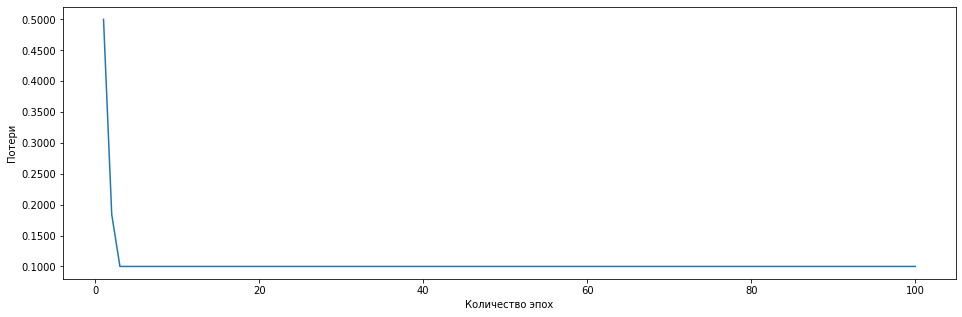

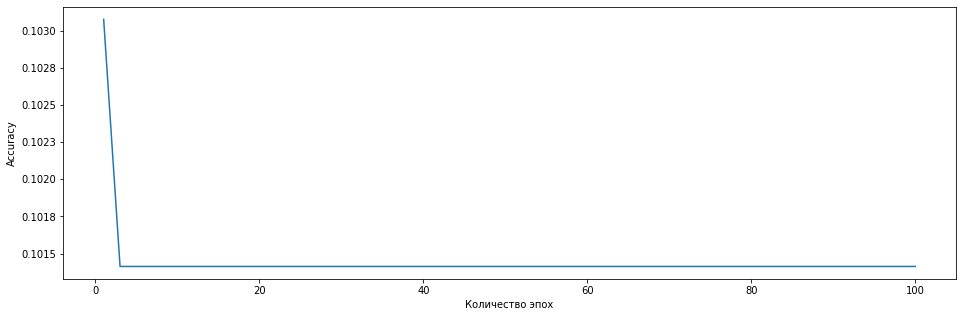

In [19]:
y_labels = [
    ('losses', 'Потери'), 
    ('metrics', 'Accuracy')
]

for key, name in y_labels:
    plot_history(range(1, len(history['train'][key]) + 1), history['train'][key], name)

Очевидно, что здесь столкнулись с "параличом сети". Веса изменились слишком быстро, и приняли значения, при которых производная сигмоиды занулила градиент. Тем самым, веса практически не менялись во время обучения.

Уменьшим learning_rate, чтобы веса менялись более плавно.

In [20]:
%%time
seed = 1

L = InputLayer(64)
L = Layer(5, L, add_bias=False, random_state=seed)
L = Layer(10, L, add_bias=False, random_state=seed)

model = NNetwork(L, learning_rate=1e-2)

history = model.fit(X_train, y_train, n_epochs=100)

CPU times: user 325 ms, sys: 769 ms, total: 1.09 s
Wall time: 152 ms


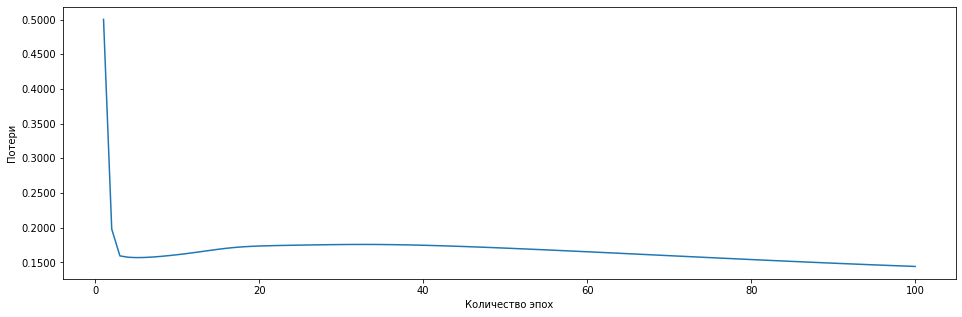

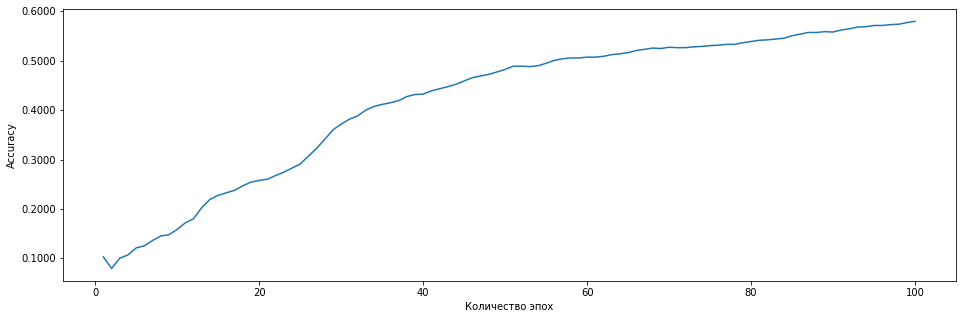

In [21]:
for key, name in y_labels:
    plot_history(range(1, len(history['train'][key]) + 1), history['train'][key], name)

Ситуация улучшилась. Проверим, как изменится ситуация при добавлении bias.

In [22]:
%%time
seed = 1

L = InputLayer(64)
L = Layer(5, L, add_bias=True, random_state=seed)
L = Layer(10, L, add_bias=True, random_state=seed)

model = NNetwork(L, learning_rate=1e-2)

history = model.fit(X_train, y_train, n_epochs=100)

CPU times: user 453 ms, sys: 650 ms, total: 1.1 s
Wall time: 152 ms


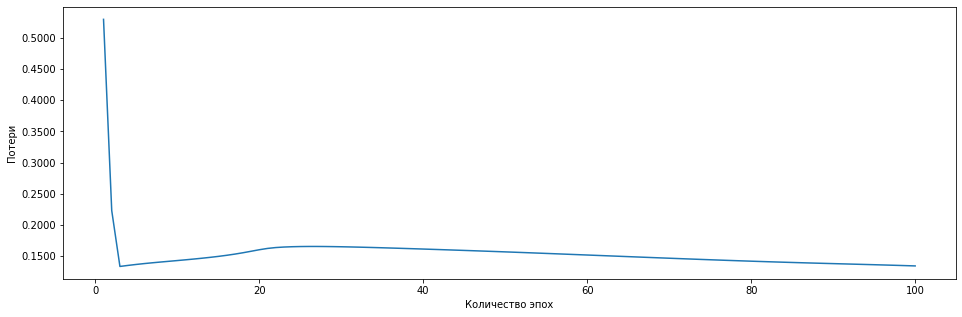

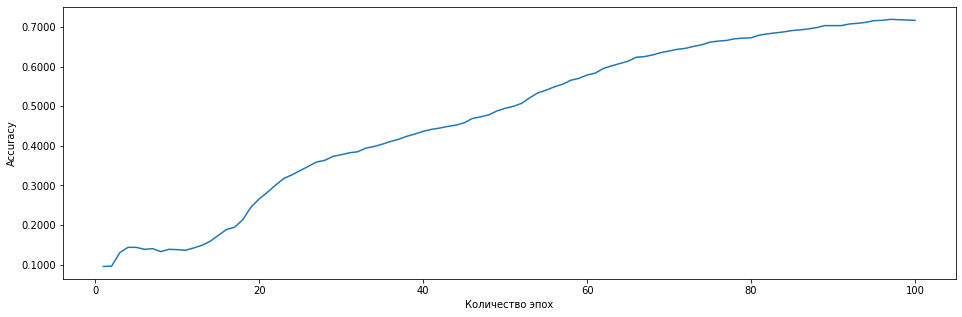

In [23]:
for key, name in y_labels:
    plot_history(range(1, len(history['train'][key]) + 1), history['train'][key], name)

При добавлении bias, accuracy превысила 0.7. Но очевидно, что количество эпох недостаточное для сходимости.

Посмотрим, как влияют различные значения learning_rate на метрику.

In [24]:
%%time
seed = 1

learning_rates = [5e-2, 1e-2, 5e-3, 1e-3, 5e-4]
# эпохи, на которых будем отображать результаты
epochs_nums = [100, 500, 1000, 2000, 3000, 5000, 10000, 15000, 20000]

results = {}

for learning_rate in learning_rates:
    
    L = InputLayer(64)
    L = Layer(5, L, add_bias=True, random_state=seed)
    L = Layer(10, L, add_bias=True, random_state=seed)

    model = NNetwork(L, learning_rate=learning_rate)
    
    # обучение моделей в течении 20000 эпох
    history = model.fit(X_train, y_train, valid_set=(X_test, y_test), n_epochs=20000)
    
    # добавление метрик только для эпох из списка
    results[(learning_rate, 'train')] = [
        metric for i, metric in enumerate(history['train']['metrics']) if (i + 1) in epochs_nums
    ]
    results[(learning_rate, 'valid')] = [
        metric for i, metric in enumerate(history['valid']['metrics']) if (i + 1) in epochs_nums
    ]

CPU times: user 8min 1s, sys: 15min 19s, total: 23min 21s
Wall time: 3min


In [25]:
results = pd.DataFrame(results, index=epochs_nums)

results.round(4)

0.0500          0.0100          0.0050          0.0010          0.0005  \
        train   valid   train   valid   train   valid   train   valid   train   
100    0.1014  0.0926  0.7165  0.6953  0.4156  0.3923  0.2228  0.2172  0.2086   
500    0.0964  0.1077  0.9177  0.8906  0.7066  0.6818  0.3732  0.3636  0.2727   
1000   0.0964  0.1077  0.9352  0.8872  0.8612  0.8199  0.4755  0.4545  0.3716   
2000   0.0964  0.1077  0.9393  0.8771  0.9102  0.8754  0.6667  0.6448  0.4572   
3000   0.0964  0.1077  0.9435  0.8855  0.9551  0.8990  0.7066  0.6801  0.6085   
5000   0.1962  0.1936  0.9534  0.8721  0.9659  0.8973  0.8246  0.7997  0.6874   
10000  0.1962  0.1936  0.9601  0.8687  0.9784  0.9024  0.9011  0.8687  0.8221   
15000  0.1962  0.1936  0.9601  0.8704  0.9800  0.9024  0.9551  0.8990  0.8861   
20000  0.1962  0.1936  0.9634  0.8586  0.9800  0.9007  0.9593  0.9108  0.9011   

               
        valid  
100    0.1953  
500    0.2643  
1000   0.3636  
2000   0.4444  
3000   0.5960  
5000   0.6650  
10000  0.7980  
15000  0.8451  
20000  0.8670

Предварительный вывод:

Learning_rate меньший/равный 0.001 показал наилучшие результаты в плане устойчивости к переобучению (метрики на тренировочном и валидационном датасетах показывают стабильный рост по мере увеличения количества эпох). Также, при данном learning_rate, равном 0.001, получена наивысшая метрика на валидационном датасете ~0.91. При более высоких learning_rate, по мере увеличения количества эпох, наблюдается повышение значения метрики на тренировочном датасете, а на валидационном метрика, либо замирает, либо показывает небольшой откат.

Возьмем за основу learning_rate равный 0.001, увеличим количество эпох и более подробно рассмотрим, как ведет себя метрика на тренировочном и валидационных датасетах.

In [26]:
def print_results(train, valid):
    print(f'\nТренировочный датасет \
    \nМаксимальная accuracy: {np.max(train):.4f}, \
    \nКоличество эпох: {np.argmax(train)}')
    print(f'\nВалидационный датасет \
    \nМаксимальная accuracy: {np.max(valid):.4f}, \
    \nКоличество эпох: {np.argmax(valid)}')
    

def plot_results(history):
    train_metrics = history['train']['metrics']
    valid_metrics = history['valid']['metrics']

    plt.figure(figsize=(16, 10))
    plt.plot(range(1, len(train_metrics) + 1), train_metrics, label='train')
    plt.plot(range(1, len(valid_metrics) + 1), valid_metrics, label='valid')
    plt.yticks(np.linspace(0, 1, 21))
    plt.xlabel('Количество эпох')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

    print_results(train_metrics, valid_metrics)

In [27]:
%%time
seed = 1

L = InputLayer(64)
L = Layer(5, L, add_bias=True, random_state=seed)
L = Layer(10, L, add_bias=True, random_state=seed)

model = NNetwork(L, learning_rate=1e-3)

history = model.fit(X_train, y_train, valid_set=(X_test, y_test), n_epochs=50000)

CPU times: user 4min, sys: 7min 41s, total: 11min 41s
Wall time: 1min 30s


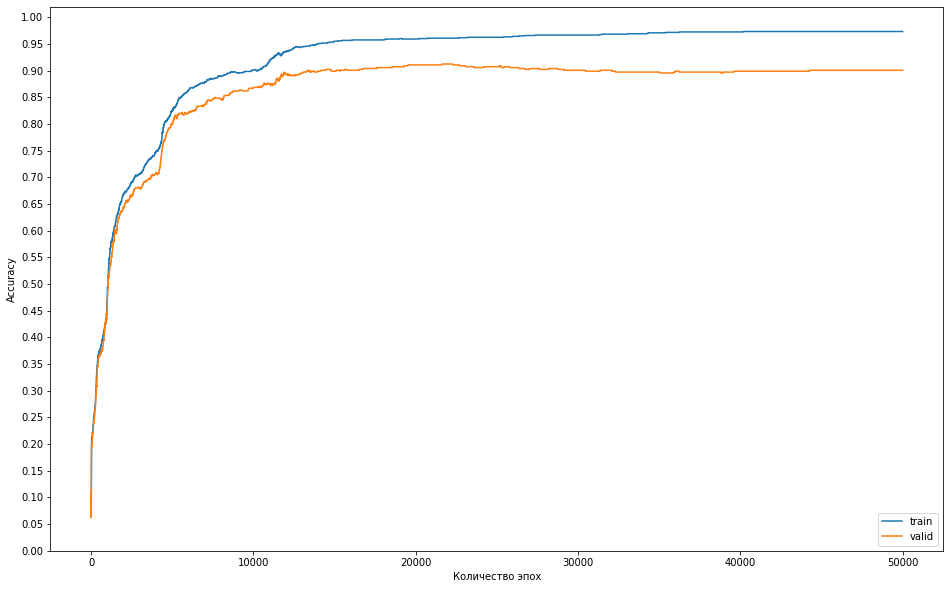


Тренировочный датасет     
Максимальная accuracy: 0.9734,     
Количество эпох: 40182

Валидационный датасет     
Максимальная accuracy: 0.9125,     
Количество эпох: 21609


In [28]:
plot_results(history)

Похоже, что при learning_rate равном 0.001 достаточно около 20000 эпох. При большем количестве начинается переобучение.

Попробуем еще уменьшить learning_rate (до 0.0005) и посмотреть на результат.

In [29]:
%%time
seed = 1

L = InputLayer(64)
L = Layer(5, L, add_bias=True, random_state=seed)
L = Layer(10, L, add_bias=True, random_state=seed)

model = NNetwork(L, learning_rate=5e-4)

history = model.fit(X_train, y_train, valid_set=(X_test, y_test), n_epochs=50000)

CPU times: user 4min 7s, sys: 8min, total: 12min 7s
Wall time: 1min 34s


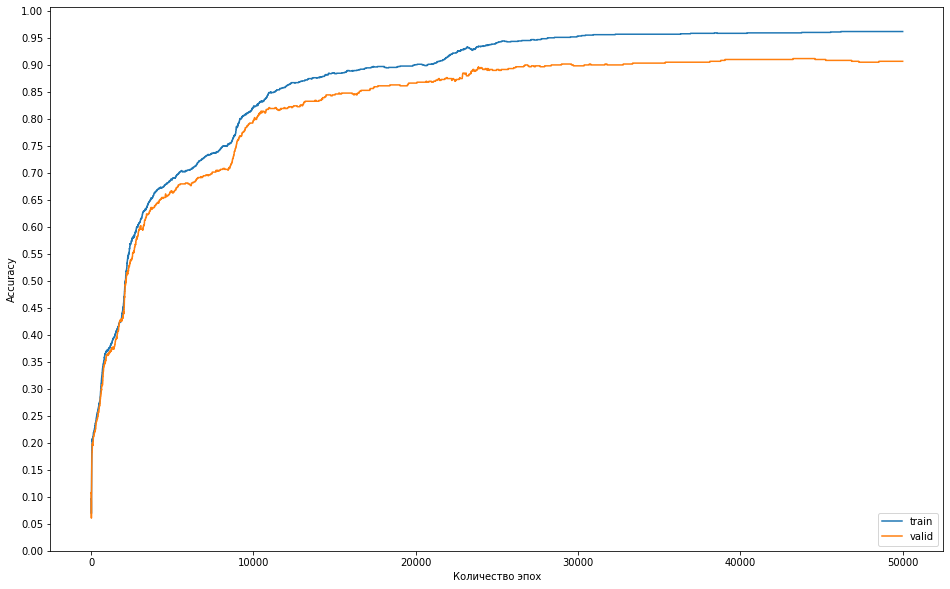


Тренировочный датасет     
Максимальная accuracy: 0.9626,     
Количество эпох: 46191

Валидационный датасет     
Максимальная accuracy: 0.9125,     
Количество эпох: 43241


In [30]:
plot_results(history)

Похоже, что при данной архитектуре сети нам не получится выжать больше.

Увеличим количество нейронов в скрытом слое.

Будем брать количество нейронов кратное 10 (по количеству классов), от 10 до 50. Learning_rate возьмем равный 0.001.

In [31]:
%%time
seed = 1

n_nums = [10, 20, 30, 40, 50]
# эпохи, на которых будем отображать результаты
epochs_nums = [100, 500, 1000, 2000, 3000, 5000, 10000, 15000, 20000]

results = {}

for n_num in n_nums:
    
    L = InputLayer(64)
    L = Layer(n_num, L, add_bias=True, random_state=seed)
    L = Layer(10, L, add_bias=True, random_state=seed)

    model = NNetwork(L, learning_rate=1e-3)
    
    # обучение моделей в течении 20000 эпох
    history = model.fit(X_train, y_train, valid_set=(X_test, y_test), n_epochs=20000)
    
    # добавление метрик только для эпох из списка
    results[(n_num, 'train')] = [
        metric for i, metric in enumerate(history['train']['metrics']) if (i + 1) in epochs_nums
    ]
    results[(n_num, 'valid')] = [
        metric for i, metric in enumerate(history['valid']['metrics']) if (i + 1) in epochs_nums
    ]

CPU times: user 17min 34s, sys: 30min 15s, total: 47min 50s
Wall time: 6min 13s


In [32]:
results = pd.DataFrame(results, index=epochs_nums)

results.round(4)

10              20              30              40              50  \
        train   valid   train   valid   train   valid   train   valid   train   
100    0.2269  0.2357  0.4896  0.5067  0.4032  0.4226  0.4730  0.4865  0.5777   
500    0.6941  0.6970  0.8529  0.8451  0.8919  0.8805  0.7307  0.7357  0.8196   
1000   0.8288  0.8249  0.9451  0.9141  0.9584  0.9444  0.8820  0.8754  0.8595   
2000   0.9368  0.9293  0.9751  0.9529  0.9784  0.9512  0.9800  0.9646  0.8770   
3000   0.9601  0.9394  0.9809  0.9562  0.9817  0.9579  0.9867  0.9680  0.8828   
5000   0.9825  0.9529  0.9892  0.9663  0.9884  0.9663  0.9950  0.9731  0.9884   
10000  0.9875  0.9613  0.9933  0.9646  0.9933  0.9714  0.9983  0.9731  0.9958   
15000  0.9884  0.9613  0.9933  0.9646  0.9942  0.9680  0.9983  0.9731  0.9983   
20000  0.9900  0.9596  0.9933  0.9663  0.9950  0.9680  0.9983  0.9731  0.9983   

               
        valid  
100    0.5875  
500    0.8081  
1000   0.8620  
2000   0.8872  
3000   0.8889  
5000   0.9697  
10000  0.9747  
15000  0.9781  
20000  0.9798

По мере увеличения количества узлов (нейронов) в скрытом слое, метрика улучшается как на тренировочном, так и на валидационном датасетах. 

Возьмем количество узлов, в скрытом слое, равное 50. И рассмотрим подробнее.

In [33]:
%%time
seed = 1

L = InputLayer(64)
L = Layer(50, L, add_bias=True, random_state=seed)
L = Layer(10, L, add_bias=True, random_state=seed)

model = NNetwork(L, learning_rate=1e-3)

history = model.fit(X_train, y_train, valid_set=(X_test, y_test), n_epochs=20000)

CPU times: user 4min 58s, sys: 8min 34s, total: 13min 32s
Wall time: 1min 47s


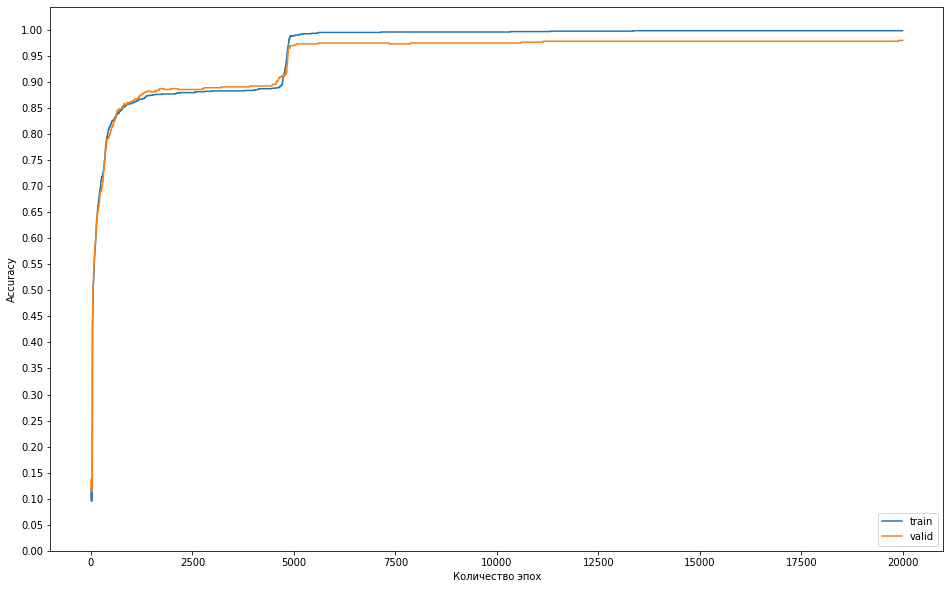


Тренировочный датасет     
Максимальная accuracy: 0.9983,     
Количество эпох: 13359

Валидационный датасет     
Максимальная accuracy: 0.9798,     
Количество эпох: 19903


In [34]:
plot_results(history)

В целом - скорость обучения возрастает, вероятно это связано с тем, что стало больше весов, и все они одновременно обновляются на каждой эпохе, быстрее уменьшая ошибку. 

Около 5000 эпох метрика значительно выросла - видимо удалось выйти из локального минимума.

Попробуем увеличить learning_rate - для уменьшения количества эпох.

In [35]:
%%time
seed = 1

L = InputLayer(64)
L = Layer(50, L, add_bias=True, random_state=seed)
L = Layer(10, L, add_bias=True, random_state=seed)

model = NNetwork(L, learning_rate=5e-3)

history = model.fit(X_train, y_train, valid_set=(X_test, y_test), n_epochs=20000)

CPU times: user 4min 59s, sys: 8min 17s, total: 13min 16s
Wall time: 1min 43s


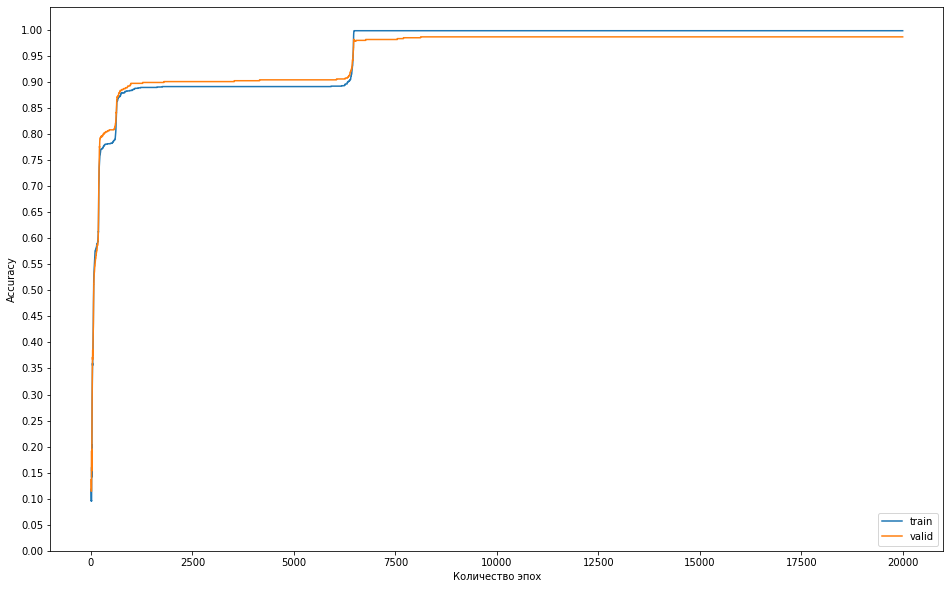


Тренировочный датасет     
Максимальная accuracy: 0.9983,     
Количество эпох: 6484

Валидационный датасет     
Максимальная accuracy: 0.9865,     
Количество эпох: 8120


In [36]:
plot_results(history)

Похоже, что удалось сократить вдвое количество эпох. В качестве бонуса - удалось увеличить метрику на валидационном датасете. Но это оценка - не объективная. Вероятнее всего отклонение в пределах статистической погрешности.

Попробуем увеличить количество слоев до 5 (4 скрытых, 1 выходной). 

In [37]:
%%time
seed = 1

L = InputLayer(64)
L = Layer(50, L, add_bias=True, random_state=seed)
L = Layer(40, L, add_bias=True, random_state=seed)
L = Layer(30, L, add_bias=True, random_state=seed)
L = Layer(20, L, add_bias=True, random_state=seed)
L = Layer(10, L, add_bias=True, random_state=seed)

model = NNetwork(L, learning_rate=1e-3)

history = model.fit(X_train, y_train, valid_set=(X_test, y_test), n_epochs=20000)

CPU times: user 11min 2s, sys: 19min 5s, total: 30min 8s
Wall time: 3min 53s


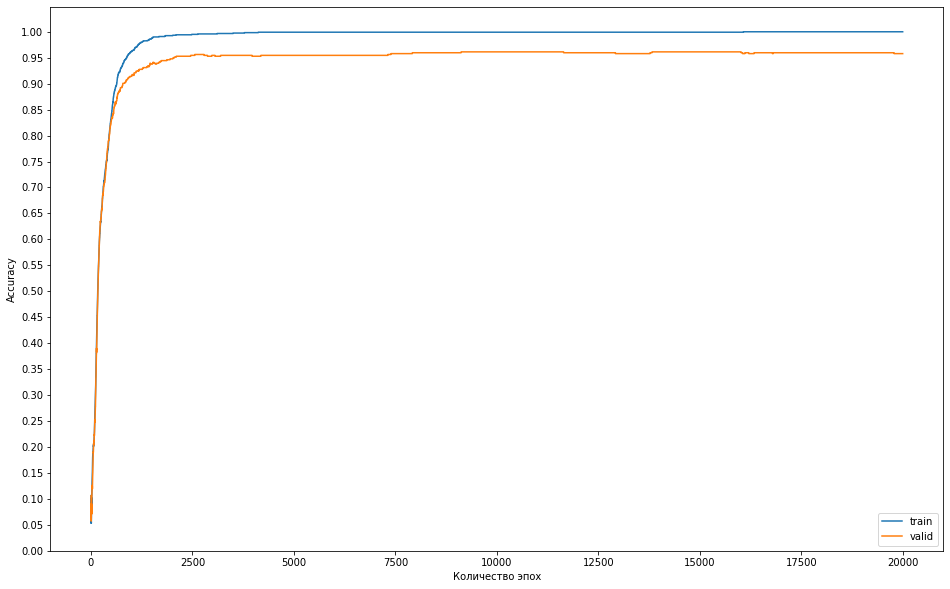


Тренировочный датасет     
Максимальная accuracy: 1.0000,     
Количество эпох: 16075

Валидационный датасет     
Максимальная accuracy: 0.9613,     
Количество эпох: 9118


In [38]:
plot_results(history)

In [39]:
%%time
seed = 1

L = InputLayer(64)
L = Layer(50, L, add_bias=True, random_state=seed)
L = Layer(40, L, add_bias=True, random_state=seed)
L = Layer(30, L, add_bias=True, random_state=seed)
L = Layer(20, L, add_bias=True, random_state=seed)
L = Layer(10, L, add_bias=True, random_state=seed)

model = NNetwork(L, learning_rate=5e-3)

history = model.fit(X_train, y_train, valid_set=(X_test, y_test), n_epochs=20000)

CPU times: user 11min 2s, sys: 18min 55s, total: 29min 57s
Wall time: 3min 50s


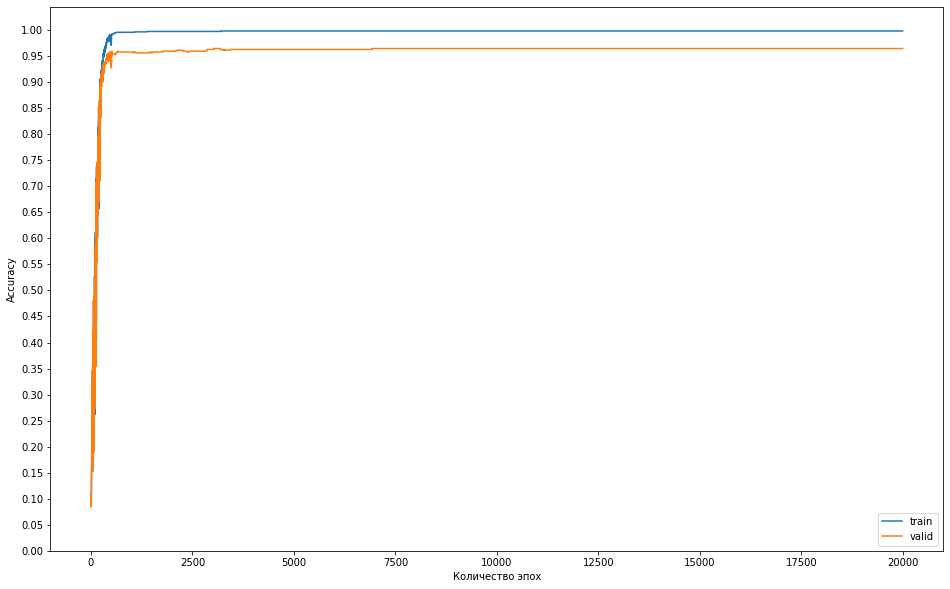


Тренировочный датасет     
Максимальная accuracy: 0.9983,     
Количество эпох: 3203

Валидационный датасет     
Максимальная accuracy: 0.9646,     
Количество эпох: 3027


In [40]:
plot_results(history)

Большое количество слоев приводит к переобучению сети. Сеть "запоминает" тренировочный набор, и хуже обобщает новые данные.

Добавим только один дополнительный слой. 

Всего 2 скрытых слоя: 

Первый скрытый (после входного) - 32 узла;

Второй скрытый - 50 узлов.

In [41]:
%%time
seed = 1

L = InputLayer(64)
L = Layer(32, L, add_bias=True, random_state=seed)
L = Layer(50, L, add_bias=True, random_state=seed)
L = Layer(10, L, add_bias=True, random_state=seed)

model = NNetwork(L, learning_rate=1e-3)

history = model.fit(X_train, y_train, valid_set=(X_test, y_test), n_epochs=20000)

CPU times: user 6min 52s, sys: 11min 57s, total: 18min 50s
Wall time: 2min 24s


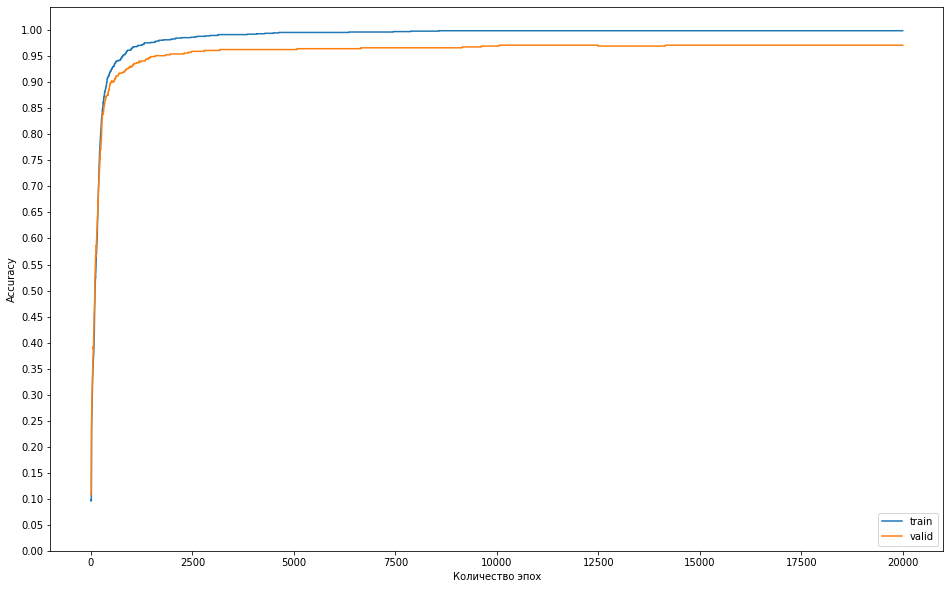


Тренировочный датасет     
Максимальная accuracy: 0.9992,     
Количество эпох: 8571

Валидационный датасет     
Максимальная accuracy: 0.9714,     
Количество эпох: 10058


In [42]:
plot_results(history)

Добавлением дополнительного слоя не удалось добиться улучшения показателя метрики на валидационном датасете. 

В контексте данной задачи - добавление дополнительных слоев приводит к переобучению сети.

**Сеть с лучшими гиперпараметрами**

In [43]:
%%time
seed = 1

L = InputLayer(64)
L = Layer(50, L, add_bias=True, random_state=seed)
L = Layer(10, L, add_bias=True, random_state=seed)

model = NNetwork(L, learning_rate=5e-3)

history = model.fit(X_train, y_train, valid_set=(X_test, y_test), n_epochs=8200)

CPU times: user 2min 4s, sys: 3min 18s, total: 5min 23s
Wall time: 41.5 s


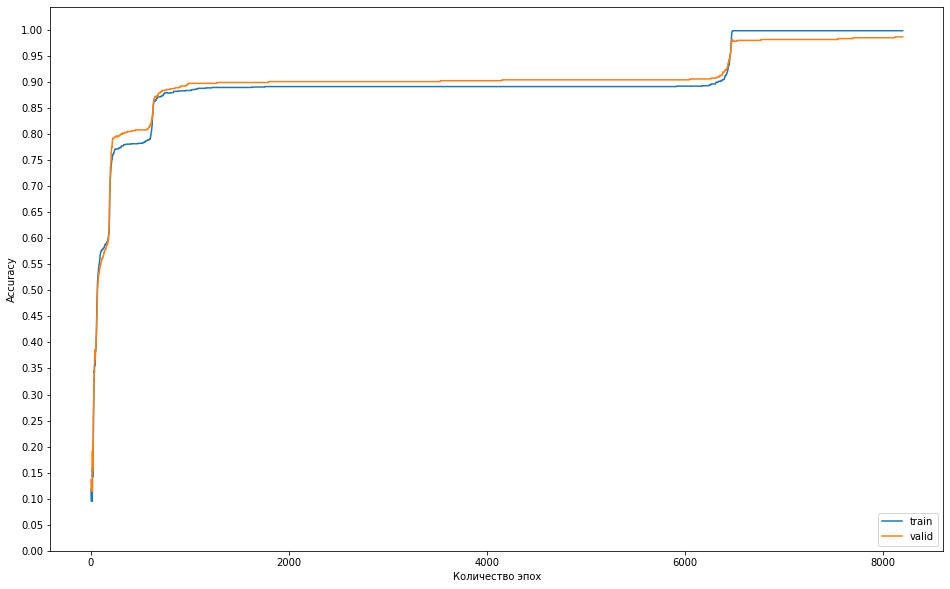


Тренировочный датасет     
Максимальная accuracy: 0.9983,     
Количество эпох: 6484

Валидационный датасет     
Максимальная accuracy: 0.9865,     
Количество эпох: 8120


In [44]:
plot_results(history)

**Проведите анализ — что приводит к ухудшению точности нейронной сети?**

Основное влияние оказывает learning_rate. Именно этот гиперпараметр отвечает за скорость обновления весов. При слишком большом learning_rate можно столкнуться с тем, что веса изменятся слишком быстро и примут значения, при которых обучение сети остановится (наступит "паралич сети"). Но при слишком маленьком learning_rate потребуется больше эпох для сходимости, тем самым увеличится время обучения. Необходим баланс.

Также немалое влияние оказывают данные, которые подаются на вход, а также начальные веса. Без нормирования данных и при неправильных начальных весах также неминуем "паралич сети".

Также некоторое влияние оказывает отсутствие свободного коэффициента (bias). 

Дополнительные слои ухудшают метрики на валидационном датасете, появляются признаки переобучения.

**Что приводит к увеличению ее точности?**

К улучшению точности приводит правильно подобранный learning_rate, количество эпох, количество узлов (нейронов) в скрытом слое. 

Дополнительные слои приводят к улучшению метрик на тренировочном датасете. На валидационном метрики ухудшаются.